<a href="https://colab.research.google.com/github/tleitch/SEC_13F_Filing/blob/master/13F_Filing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The purpose of this script is to grab investment gurus' portfolio from their 13F filings, analyze their portfolio and potientially used it to inform stock selection decisions

### Things I look for:
##### 1. Number of shares increase over time
##### 2. Stock is one of the larger positions in the portfolio
##### 3. Current price is similar to when guru purchased it
##### 4. A lot of gurus has the position

In [1]:
import requests
from lxml import html, etree

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from ipywidgets import interact, Dropdown, widgets
from IPython.display import display, HTML


%matplotlib inline
import matplotlib.pyplot as plt
!pip install edgar
import  edgar 

### Set up classes for retrieving the 13F and processing them

__`edgar`__: based on the fund CIK number and retrieve the 13F filings

* each fund will be its own class
* each class can retrieve its historical 13F filings
Process: initialized class --> specify filing type (get_all_fiings) --> download all the htmls (get_documents)




__`digest_13F`__: takes the output from edgar class and parse the 13F into panda dataframe

* For amended 13F. Seth is the only person who's amended 13F is a replacement. Everyone else's amended filing is only an addition. So the class will make special adjustment for seth
Process: initialized class --> parse individual 13F (scrape_13f) --> __map tickers__ --> combining quarter 13F into one (all_13f)
* map tickers: Details from notebook `CUSIP Parser`

In [2]:
class edgar():
    '''this class will get filings from SEC edgar. 
    Part of the functions are copy from https://pypi.org/project/edgar/'''

    def __init__(self, name, cik, timeout=10):
        self.name = name
        self.cik = cik
        self.url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK={}'.format(cik)
        self.timeout = timeout
        self._document_urls = []
        
        
    def get_request(self, href, isxml=False, timeout=10): # function to send get request
        page = requests.get(href, timeout=timeout)
        if isxml:
            p = etree.XMLParser(huge_tree=True)
            return etree.fromstring(page.content, parser=p)
        else:
            return html.fromstring(page.content)
    
    
    def get_filings_url(self, filing_type="", prior_to="", ownership="include", no_of_entries=100):
        '''set up the url for documents'''
        url = self.url + "&type=" + filing_type + "&dateb=" + prior_to + "&owner=" +  ownership + "&count=" + str(no_of_entries)
        return url
 
      
    def get_all_filings(self, filing_type="", prior_to="", ownership="include", no_of_entries=100):
        '''filter the page for all the desired filings. This feed into get_documents which will pull the filings'''
        url = self.get_filings_url(filing_type, prior_to, ownership, no_of_entries)
        page = requests.get(url, timeout=self.timeout)
        return html.fromstring(page.content)
    
    
    def get_documents(self, tree, no_of_documents=1, debug=False):
        BASE_URL = "https://www.sec.gov"
        elems = tree.xpath('//*[@id="documentsbutton"]')[:no_of_documents] # getting sublinks 
        result = []
        
        # the following are modified by Richard. If its 13f we get it from row 6 rather than row 2
        if '13F' in html.tostring(tree).decode("utf-8"):
            for elem in elems:
                url = BASE_URL + elem.attrib["href"]
                content_page = self.get_request(url)
                if debug:
                    print(elem)
                    print("URL:", url)
                    print("FORM:", content_page.find_class("formContent")[0].text_content())
                try:
                    url = BASE_URL + content_page.xpath('//*[@id="formDiv"]/div/table/tr[6]/td[3]/a')[0].attrib["href"]
                    filing = self.get_request(url)
                    result.append(filing)
                except IndexError:
                    filing=None
        else:
            for elem in elems:
                url = BASE_URL + elem.attrib["href"]
                content_page = self.get_request(url)
                if debug:
                    print("URL:", url)
                    print("FORM:", content_page.find_class("formContent")[0].text_content())
                url = BASE_URL + content_page.xpath('//*[@id="formDiv"]/div/table/tr[2]/td[3]/a')[0].attrib["href"]
                filing = self.get_request(url)
                result.append(filing)

        if len(result) == 1:
            return result[0]
        return result

In [19]:
class digest_13f():

    def __init__(self, fund_name, docs):
        
        self.CUSIP = pd.read_csv('https://raw.githubusercontent.com/tleitch/SEC_13F_Filing/master/CUSIP/CUSIP.csv') # read in the CUSIP file
        self.missing_tickers = {} # store companys with missing tickers. CUSIP: name
        self.latest_filing = ''
        self.num_of_quarter = 0
        
        self.fund_name = fund_name
        self.docs = docs
        
        self.df = pd.DataFrame()
        
        
        
    
    # this funtion can scrape individual 13F and put them into a dataframe
    def scrape_13f(self, html):
        '''takes the output from get documents and scrape the 13f into dataframe'''
        
        soup = BeautifulSoup(html, 'lxml')
        rows = soup.find_all('infotable')
        positions = []

        for row in rows:
            dic = {}
            # scraping information from the html
            dic['name_of_issuer'] = row.find_all('nameofissuer')[0].text
            dic['title_of_class'] = row.find_all('titleofclass')[0].text
            dic['CUSIP'] = row.find_all('cusip')[0].text
            dic['value'] = int(row.find_all('value')[0].text.replace(',', ''))*1000
            dic['shares'] = int(row.find_all('sshprnamt')[0].text.replace(',', ''))
            dic['SH_PRN'] = row.find_all('sshprnamttype')[0].text
            dic['discretion'] = row.find_all('investmentdiscretion')[0].text
            # put the dictionary into the list 
            positions.append(dic)

        # turn the list into dataframe
        try:
           df = pd.DataFrame(positions)
        
           df['file_type'] = soup.find_all('submissiontype')[0].text #name of the filing '13F-HR/A' means ammended filing
        
           # data of the the calendar
           df['quarter_end'] = pd.to_datetime(soup.find_all('reportcalendarorquarter')[0].text,format='%m-%d-%Y')
        
           # dates of reporting
           df['signature_date'] = pd.to_datetime(soup.find_all('signaturedate')[0].text,format='%m-%d-%Y')
                                            
           return df

        except IndexError:
          return None
    
    def all_13f(self):
        '''scrape each 13F and put all into a dataframe'''
        list_df = []
        for doc in self.docs:
            
            doc = html.tostring(doc) # the edgar class outputs element. Transform it into string
            df = self.scrape_13f(doc) # get the 13F into dataframe
            if bool(df):
              df['fund'] = self.fund_name # added fund name
              list_df.append(df) # append to list
        
              self.df = pd.concat(list_df)
        
              self.latest_filing = self.df.quarter_end.max()
              self.num_of_quarter = len(self.df.quarter_end.unique())
    
    def df_cleaning(self):
        
        self.all_13f()
        
        if self.fund_name in ['Seth', 'Guy']: # Seth and Guy's revision is replacement, so get the 13F with latest signature data
            
            # get the latest signature date by quater. This will get the revision 13F since it will have later date
            max_signature_date = self.df.groupby(['quarter_end'])[['signature_date']].max().reset_index()

            # inner join to get the latest filing by quarter
            self.df = pd.merge(self.df, max_signature_date, how='inner', on=['quarter_end', 'signature_date'])
            

            
        self.df = pd.merge(self.df, self.CUSIP, how='left', on='CUSIP')  # append tickers


        
        # Store the missing CUSIP stocks.
        CUSIP_missing_ticker = self.df[self.df.Ticker.isna()].CUSIP.tolist()
        name_missing_ticker = self.df[self.df.Ticker.isna()].name_of_issuer.tolist()
        self.missing_tickers = {CUSIP: name for CUS, name in zip(CUSIP_missing_ticker, name_missing_ticker)}
        
        
        
        # replace the missing ticker with name for now
        # CUSIP are leave out since some stock have different class which has different CUSIP
        # name_of_issuer: the stock name is not very standarized as well.
        self.df.Ticker = np.where(self.df.Ticker.isna(), 'NA' + self.df.name_of_issuer, self.df.Ticker)
        
        self.df = self.df.groupby(['fund', 'quarter_end', 'Ticker'])\
                         .agg({'value': 'sum', 'shares': 'sum'})\
                         .reset_index(drop=False)

        
        # calculating addition information based on the table
        
        self.df['share_price'] = self.df.value / self.df.shares
        
        def current_quarter_info(df):
    
            total_value = df.value.sum() # total portfolio value for the quarter

            df['quarterly_weights'] = df.value/total_value
            df['quarterly_rank'] = df.value.rank(ascending=False)

            return(df)

        # rank and calculate stock weights
        self.df = self.df.groupby(['fund', 'quarter_end']).apply(current_quarter_info)
        
        
        
        # calculate quarter over quarter changes
        
        self.df['prior_q'] = self.df.quarter_end - pd.offsets.MonthOffset(3) + pd.offsets.MonthEnd(0)

        prior_data = self.df[['Ticker', 'quarter_end', 'shares', 'quarterly_weights']]
        prior_data.columns = ['Ticker', 'prior_q', 'prior_q_shares', 'prior_q_quarterly_weights']

        self.df = pd.merge(self.df, prior_data, how='left', on=['Ticker', 'prior_q']) # join with prior quarter data
        self.df['shares_qoq'] = self.df.shares / self.df.prior_q_shares - 1
        self.df.shares_qoq.fillna(10, inplace=True)
        self.df.prior_q_shares.fillna(0, inplace=True)
        
        self.df['weights_qoq'] = self.df.quarterly_weights - self.df.prior_q_quarterly_weights.fillna(0)

### Typing the CIK number,  retrieve the 13F and ingest them

In [15]:
# list of gurus I want to track and their cik
cik={'Buffett': '0001067983', 'Mohnish': '0001549575', 'Seth': '0001061768', 'Carl': '0000921669', 
     'TCI_Chris': '0001647251', 'Pershing_Ackman': '0001336528', 'Greenlight_Einhorn': '0001079114',
     'Himalaya_Li_Lu': '0001709323', 'David_Tepper': '0001656456', 'Dalio':'0001350694', 
     'Guy': '0001404599'}

In [5]:
# Getting 13F for each guru and save them into a dictionary

docs_dict = {}

for guru in cik:
    print(guru)
    fund = edgar(name=guru, cik=cik[guru]) # load the fund
    tree = fund.get_all_filings(filing_type='13F-HR') # get individual links
    docs = fund.get_documents(tree=tree, no_of_documents=20,debug=False) # getting the html for all 
    
    docs_dict[guru] = docs # attach the 13f into docs dictionary
    
    print('{:<2} 13f from {:<20} is loaded'.format(len(docs) ,guru))

Buffett
18 13f from Buffett              is loaded
Mohnish
14 13f from Mohnish              is loaded
Seth
0  13f from Seth                 is loaded
Carl
14 13f from Carl                 is loaded
TCI_Chris
0  13f from TCI_Chris            is loaded
Pershing_Ackman
0  13f from Pershing_Ackman      is loaded
Greenlight_Einhorn
0  13f from Greenlight_Einhorn   is loaded
Himalaya_Li_Lu
10 13f from Himalaya_Li_Lu       is loaded
David_Tepper
13 13f from David_Tepper         is loaded
Dalio
12 13f from Dalio                is loaded
Guy
17 13f from Guy                  is loaded


In [20]:
# scrape the 13F into dictionary of dataframe

data={}

for guru in docs_dict:
    print(guru)
    docs = docs_dict[guru]
    if bool(docs) :
      data_13f = digest_13f(fund_name=guru, docs=docs) # initialized the scrapping class
      data_13f.df_cleaning() # scrape all into df
      data[guru] = data_13f.df # get the df into dictionary
    
      num_of_position = data[guru][data[guru].quarter_end == data_13f.latest_filing].shape[0]
    
      string = 'Latest filing: {} | # of 13F from {:<20} are loaded: {:<2} | num of positions: {:<2}'
      print(string.format(data_13f.latest_filing.date(), guru, data_13f.num_of_quarter, num_of_position))
      print('missing tickers', data_13f.missing_tickers)

Buffett


ValueError: ignored

### Plot the size of the each guru's portfolio over time

In [21]:
# create the value of each fund by time

agg = pd.concat(list(data.values()))
agg = agg.groupby(['quarter_end', 'fund']).value.sum().unstack()/1000000000


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

agg.plot(ax=axes[0], marker='o')
axes[0].set_ylabel('Billions', fontweight='bold')
axes[0].set_title('Fund Size Over Time\n All Funds', fontweight='bold')
axes[0].legend(bbox_to_anchor=(1,1))
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=-45, horizontalalignment='left')



agg.drop(['Buffett'], axis='columns').plot(ax=axes[1], marker='o')
axes[1].set_ylabel('Billions', fontweight='bold')
axes[1].set_title('Fund Size Over Time\n Smaller Funds', fontweight='bold')
axes[1].legend(bbox_to_anchor=(1,1))
# axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=-45, horizontalalignment='left')


plt.tight_layout()

ValueError: ignored

### Plot the size of the individual guru's portfolio over time

interactive(children=(Dropdown(description='Guru', options=('Buffett', 'Mohnish', 'Seth', 'Carl', 'TCI_Chris',…

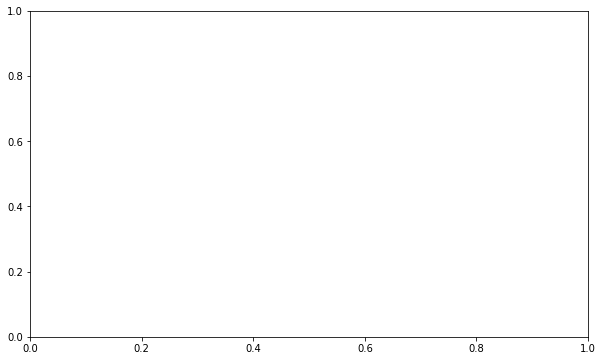

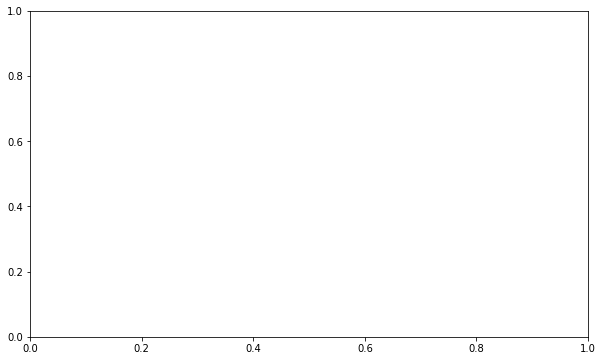

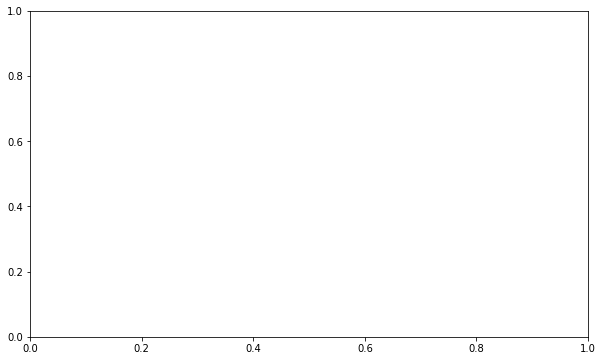

In [22]:
def plot_guru(guru):
    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(agg.index, agg[guru], marker='o')  
    
    ax.set_ylabel('Billions', fontweight='bold')
    ax.set_title('{} Fund Size Over Time'.format(guru), fontweight='bold')

investor = Dropdown(options=list(cik.keys()), value=list(cik.keys())[0], description='Guru')

_ = interact(plot_guru, guru=investor)

## Showing top buy and top sell

In [23]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def top_action(num_of_position, action):

    ascending = action != 'buy'
    agg = pd.concat(list(data.values()))
    agg = agg[['quarter_end', 'fund', 'Ticker', 'shares', 'prior_q_shares', 'shares_qoq', 'weights_qoq']]
    display(agg[agg.quarter_end == agg.quarter_end.max()].sort_values(by='weights_qoq', ascending=ascending)[:num_of_position])

    
num_of_position = Dropdown(options=range(5,51), value=10, description='num_of_position')

print(color.BOLD + 'top buys:\n', '-'*80)
_ = interact(lambda num_of_position: top_action(num_of_position, 'buy'), num_of_position=num_of_position)

top buys:
 --------------------------------------------------------------------------------


interactive(children=(Dropdown(description='num_of_position', index=5, options=(5, 6, 7, 8, 9, 10, 11, 12, 13,…

In [ ]:
print(color.BOLD + 'top sells:\n', '-'*80)
_ = interact(lambda num_of_position: top_action(num_of_position, 'sell'), num_of_position=num_of_position)

### Most Common Holdings and Most conviction Holdings

In [ ]:
def common_holding(df):
    
    df = df.sort_values(by='quarterly_weights', ascending=False)
    
    return(pd.Series({'guru_count': df.shape[0], 
                          'avg_weights': df.quarterly_weights.mean(), 
                          'gurus': dict(zip(df.fund.tolist(), df.quarterly_weights.round(2).tolist()))}))


print(color.BOLD + 'Common Holding:\n', '-'*80)

agg = pd.concat(list(data.values()))
agg = agg[agg.quarter_end == agg.quarter_end.max()]

agg[['fund', 'Ticker', 'quarterly_weights']].groupby('Ticker')\
                                            .apply(common_holding)\
                                            .sort_values(by='guru_count', ascending=False)[:20]

In [ ]:
print(color.BOLD + 'Most Conviction Holding:\n', '-'*80)

agg = pd.concat(list(data.values()))
agg = agg[agg.quarter_end == agg.quarter_end.max()]

agg[['fund', 'Ticker', 'quarterly_weights']].groupby('Ticker')\
                                            .apply(common_holding)\
                                            .sort_values(by='avg_weights', ascending=False)[:20]

### Showing the current portfolio's change over last two quarters

In [ ]:
def color_column(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    
    if val < 0:
        color = 'red'
    elif val > 0:
        color = 'blue'
    else:
        color = 'black'

    return 'color: %s' % color


def guru_portfolio(guru, num_of_position):
    
    guru_data = data[guru].copy()

    guru_data = guru_data[guru_data.quarter_end > guru_data.quarter_end.unique()[-3]]
    
    guru_data = guru_data[['fund', 'Ticker', 'quarter_end', 'shares_qoq', 'quarterly_weights']]\
                            .set_index(['fund', 'Ticker', 'quarter_end'])\
                            .unstack()

    sort_index = guru_data[('quarterly_weights', )].sum(axis=1).sort_values(ascending=False).index

    
    
    col = guru_data.columns[:2]
#     guru_data = guru_data

    
    display(guru_data.loc[sort_index, :][:num_of_position].style.applymap(color_column, subset=col))
    
investor = Dropdown(options=list(cik.keys()), value=list(cik.keys())[0], description='Guru')
num_of_position = Dropdown(options=range(5,51), value=10, description='num_of_position')


_ = interact(guru_portfolio, guru=investor, num_of_position=num_of_position)

# Function to create a dropdown list where I can easily select a guru and plot guru's top stock positions over time

In [ ]:

def plot_holding(guru,size_rank):
    
    # during the change, size rank will be none for a quick moment, use this to take care of that
    if size_rank is not None:

        plt_data = data[guru]
        max_date = plt_data['quarter_end'].max()
        latest_13F = plt_data[plt_data.quarter_end == max_date]

        # get the latest quarter holding and rank it by size, then grab the security name
        num_company=len(plt_data[plt_data['quarter_end'] == max_date])

        if size_rank > num_company:
            size_rank = num_company
            size_rank = max(size_rank,2) # make the min to be 2 so the axes from the fig is always a numpy array


        fig, axes = plt.subplots(size_rank, 1, figsize=(10, 4*size_rank), sharex=True)

        for i in range(min(size_rank, num_company)): # if the company is 1, then only loop once
            
            rank = i + 1
            
            ticker = latest_13F.loc[latest_13F.quarterly_rank == rank, 'Ticker'].values[0]
            percentage = latest_13F.loc[latest_13F.quarterly_rank == rank, 'quarterly_weight'].values[0]
    
            
            # get the security data over time
            security = plt_data[(plt_data.Ticker == ticker)]
            
            # width has to be set high otherwise, bars will not be visiable
            axes[i].bar(security['quarter_end'].dt.date, security['shares'], label='Share', color='darkorange', width=30)
            

            axes2 = axes[i].twinx()
            axes2.plot(security['quarter_end'].dt.date, security['share_price'], 
                       marker='o', label='Price', color='slateblue')
            
            # config the graph
            axes[i].tick_params(axis='x', rotation=-45)
            axes[i].xaxis.set_tick_params(which='both', labelbottom=True)
            
            axes[i].set_title('{} | {:.2%} of the {} rank {}'.format(ticker, percentage, guru, rank))
            
            axes[i].set_ylabel('Share Count', color='darkorange', fontweight='bold')
            axes2.set_ylabel('Share Price', color='slateblue', fontweight='bold', rotation=270, labelpad=20)
            
            # set the y_lim, so small change will not show up as big change just due to the scale
            axes[i].set_ylim(0, security['shares'].max()*1.2)
            axes2.set_ylim(0, (security['share_price']).max()*1.2)

            axes[i].legend(loc='upper left')
            axes2.legend(loc='upper right')

#             axes[i].xaxis.set_tick_params(labelbottom=True) # turn on the xlabels for all graph

        fig.tight_layout()



In [ ]:
# creating the interactive drop down list
investor = Dropdown(options=list(cik.keys()), value=list(cik.keys())[0], description='Guru')

rank = Dropdown(options=range(5,51), value=5, description='Rank')


interact(plot_holding, guru=investor, size_rank=rank);